# Style Memory: Binary

## Prelims

In [109]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

import torch
dtype = torch.float
import NeuralNetwork as NN
import Layer
import importlib
import time
from copy import deepcopy
from IPython.display import display
from ipywidgets import FloatProgress

if torch.cuda.is_available():
    device = torch.device("cuda:0") # Uncomment this to run on GPU
else:
    device = torch.device("cpu")

def PrettyArray(x):
    return '['+'%0.2f '*len(x) % tuple(x)+']'

importlib.reload(NN)
importlib.reload(Layer);

## XOR

In [128]:
# XOR with additional bit
noise = 0.0
n_samples = 4

# Only 2nd component works (in general)
# Works when using tanh and 700 epochs!!!
s = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
e = np.array([[1,0],[0,1],[0,0],[1,1]], dtype=float)

# Only 2nd component works
# s = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
# e = np.array([[0,1],[1,0],[1,1],[0,0]], dtype=float)

# Only 1st component works
# s = np.array([[0,0],[1,0],[0,1],[1,1]], dtype=float)
# e = np.array([[1,0],[0,1],[1,1],[0,0]], dtype=float)

# Works
# s = np.array([[1,0],[0,1],[1,1],[0,0]], dtype=float)
# e = np.array([[1,0],[0,1],[0,0],[1,1]], dtype=float)

# Works
# s = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
# e = np.array([[1],[0],[0],[1]], dtype=float)

#s = s*2. - 1.
#e = e*2. - 1.
classes = len(s)
training_input = []
training_output = []
r = 0
for n in range(n_samples):
    training_input.append(np.array(s[r], dtype=float) + noise*np.random.normal(scale=0.01,size=len(s[r])))
    training_output.append(np.array(e[r], dtype=float))
    r = np.mod(r+1, classes) #r = np.random.randint(classes)

training_input = torch.tensor(training_input).float().to(device)
training_output = torch.tensor(training_output).float().to(device)

n_test_samples = 100
test_input = []
test_output = []
r = 0
for n in range(n_test_samples):
    test_input.append(np.array(s[r], dtype=float) + noise*np.random.normal(scale=0.01,size=len(s[r])))
    test_output.append(np.array(e[r], dtype=float))
    r = np.mod(r+1, classes) #np.random.randint(classes)

test_input = torch.tensor(test_input).float().to(device)
test_output = torch.tensor(test_output).float().to(device)

if False:
    train = [training_input, training_output]
    test = [test_input, test_output]
else:
    train = [training_output, training_input]
    test = [test_output, test_input]

for x, t in zip(s,e):
    print(str(np.array(x,dtype=int))+' -> '+str(t))

[0 0] -> [1. 0.]
[0 1] -> [0. 1.]
[1 0] -> [0. 0.]
[1 1] -> [1. 1.]


## Network

In [184]:
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=2))
#net.AddLayer(Layer.PELayer(n=10))
net.AddLayer(Layer.PELayer(n=5))
net.AddLayer(Layer.TopPELayer(n=2))
net.Connect(0,1, 'tanh')
net.Connect(1,2, 'tanh')
#net.Connect(2,3)
#net.layers[0].SetActivationFunction('blah')
#net.layers[1].SetActivationFunction('logistic')
#net.layers[2].SetActivationFunction('identity')
#net.layers[3].SetActivationFunction('logistic')
net.layers[0].Sigma = 1.
net.SetTau(0.08)

In [175]:
# Weights = [  np.array([
#     [0.3261,   -0.4540],
#    [-0.3906,   -0.5110],
#     [0.3181,    0.3108],
#     [0.3613,    0.6377],
#    [-0.7999,   -0.2880]]),
#            np.array([[0.5610,    0.3507,   -0.9866 ,   0.2043,   -0.2265]])]

# Biases = [np.zeros((5), dtype=float), np.array([0.])]

# # Construct a PE network using the same weight matrices.
# # But construct it upside-down, so that it projects top
# # to bottom.
# net.connections[1].W = torch.tensor(deepcopy(Weights[0])).float().to(device)
# net.connections[1].M = torch.tensor(deepcopy(Weights[0].transpose())).float().to(device)

# net.connections[0].W = torch.tensor(deepcopy(Weights[1])).float()
# #net.connections[0].W = torch.cuda.FloatTensor(deepcopy(Weights[1]))
# net.connections[0].M = torch.tensor(deepcopy(Weights[1].transpose())).float().to(device)

# net.layers[1].b = torch.tensor(deepcopy(Biases[0])).float().to(device)
# net.layers[0].b = torch.tensor(deepcopy(Biases[1])).float().to(device)

In [185]:
rh = net.FastLearn(train[0], train[1], epochs=700, batch_size=4, shuffle=True)

A Jupyter Widget

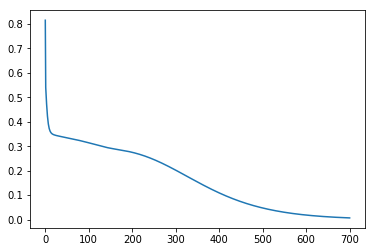

In [186]:
plt.plot(np.array(rh));
#print(rh)

In [188]:
# Forward
#net.layers[1].Probe(True)
net.Reset()
y = np.array(net.Predict(5., test[0]))
y_true = test[1]
for xx, yy, t in zip(test[0][:10], y[:10], y_true[:10]):
    print(PrettyArray(yy), PrettyArray(t))

[-0.28 0.41 ] [0.00 0.00 ]
[-0.06 0.99 ] [0.00 1.00 ]
[1.06 0.24 ] [1.00 0.00 ]
[0.67 0.81 ] [1.00 1.00 ]
[-0.28 0.41 ] [0.00 0.00 ]
[-0.06 0.99 ] [0.00 1.00 ]
[1.06 0.24 ] [1.00 0.00 ]
[0.67 0.81 ] [1.00 1.00 ]
[-0.28 0.41 ] [0.00 0.00 ]
[-0.06 0.99 ] [0.00 1.00 ]


In [187]:
# Backward
#net.layers[1].Probe(True)
net.Reset()
y = np.array(net.Generate(5., test[1]))
y_true = test[0]
for xx, yy, t in zip(test[1][:10], y[:10], y_true[:10]):
    print(PrettyArray(yy), PrettyArray(t))

[0.99 0.02 ] [1.00 0.00 ]
[0.01 1.00 ] [0.00 1.00 ]
[0.01 -0.00 ] [0.00 0.00 ]
[0.99 1.00 ] [1.00 1.00 ]
[0.99 0.02 ] [1.00 0.00 ]
[0.01 1.00 ] [0.00 1.00 ]
[0.01 -0.00 ] [0.00 0.00 ]
[0.99 1.00 ] [1.00 1.00 ]
[0.99 0.02 ] [1.00 0.00 ]
[0.01 1.00 ] [0.00 1.00 ]


## Train the Network

In [99]:
net.Reset()
net.BackprojectExpectation(train[1][0])
net.PropagateErrors(train[0][0])
net.Infer(2.0, train[0][0], train[1][0], dt=0.005, learn=False)

In [100]:
net.layers[1].v

tensor([ 0.1821, -0.0360,  0.2136, -0.1688, -0.2956])

In [101]:
net.ShowState()

Layer 0 (input):
  v = [1. 0.]
  e = [ 0.60143757 -0.18948078]
Layer 1:
  v = [ 0.1820866  -0.03599289  0.21360093 -0.1688009  -0.29559496]
  e = [ 0.18208148 -0.03599147  0.21359986 -0.16880046 -0.2955918 ]
Layer 2 (expectation):
  v = [-8.7136343e-10 -1.1132067e-06]


In [117]:
net.layers[1].Probe(False)
net.learning_tau = 2.
net.learning_blackout = 1.
rh = net.Learn(train[0], train[1], epochs=600, dt=0.01, batch_size=4, shuffle=True)

A Jupyter Widget

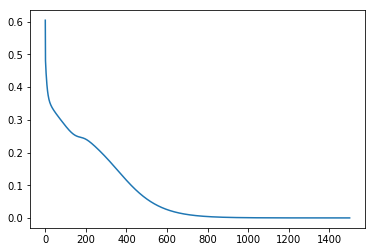

In [118]:
plt.plot(np.array(rh));
#print(rh)

## Test

In [119]:
# Forward
#net.layers[1].Probe(True)
net.Reset()
y = np.array(net.Predict(5., test[0]))
y_true = test[1]
for xx, yy, t in zip(test[0][:10], y[:10], y_true[:10]):
    print(PrettyArray(yy), PrettyArray(t))

[-0.16 0.41 ] [0.00 0.00 ]
[0.00 0.99 ] [0.00 1.00 ]
[0.76 -0.07 ] [1.00 0.00 ]
[0.58 0.88 ] [1.00 1.00 ]
[-0.16 0.41 ] [0.00 0.00 ]
[0.00 0.99 ] [0.00 1.00 ]
[0.76 -0.07 ] [1.00 0.00 ]
[0.58 0.88 ] [1.00 1.00 ]
[-0.16 0.41 ] [0.00 0.00 ]
[0.00 0.99 ] [0.00 1.00 ]


In [120]:
# Backward
#net.layers[1].Probe(True)
net.Reset()
y = np.array(net.Generate(5., test[1]))
y_true = test[0]
for xx, yy, t in zip(test[1][:10], y[:10], y_true[:10]):
    print(PrettyArray(yy), PrettyArray(t))

[0.68 0.15 ] [1.00 0.00 ]
[0.00 1.00 ] [0.00 1.00 ]
[0.00 0.00 ] [0.00 0.00 ]
[1.00 1.00 ] [1.00 1.00 ]
[0.68 0.15 ] [1.00 0.00 ]
[0.00 1.00 ] [0.00 1.00 ]
[0.00 0.00 ] [0.00 0.00 ]
[1.00 1.00 ] [1.00 1.00 ]
[0.68 0.15 ] [1.00 0.00 ]
[0.00 1.00 ] [0.00 1.00 ]


In [154]:
test[0][0]

tensor([ 1.,  0.])

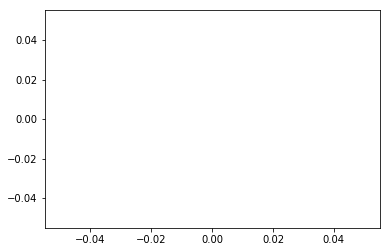

In [45]:
plt.plot(net.t_history, net.layers[1].v_history)

In [ ]:
net.ShowState()

# net.ShowWeights()

In [ ]:
net.connections[1].M

In [ ]:
net.ShowBias()

In [ ]:
net.ShowState()